# Statistical Arbitrage Strategy Research - v1

**Author**: [Darren Dube](https://linkedin.com/in/darrendube)   
**Date**: Nov 2025  
**Description**: StatArb strategy based on cointegration tests and spread modelling with KDE     
*(part of my [ByteQuant](https://github.com/darrendube/bytequant) trading engine project)*  

---
This notebook is intended to explain and visualise the reasoning behind ByteQuant's basic initial statistical arbitrage strategy (which will be expanded on over time).

Imports:

In [110]:
# stats
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import coint
import statsmodels.api as sm

# plotting
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

# utils
import os
import random
from itertools import combinations

A simple helper function to extract Close price data for a stock:

In [3]:
def get_closing_data(file_name):
    stock = pd.read_parquet(f'../src/data/processed/{file_name}')
    return stock['Close']

The following function performs a cointegration test between two stock price series in a given `window_length`:

In [5]:
def test_coint_pair(file1, file2, window_length=252):
    symbol1, symbol2 = file1.replace('.parquet',''), file2.replace('.parquet', '')
    combined = pd.concat([get_closing_data(file1), get_closing_data(file2)], axis=1, join='inner').dropna()
    
    # the default return object if there is an error in the test
    blank_df = pd.DataFrame([{
            'symbol_1': symbol1,
            'symbol_2': symbol2,
            'p_value': np.nan
        }])

    if len(combined) < window_length:
        return blank_df

    # only test for cointegration for the last `window_length` trading days
    combined = combined.iloc[-window_length:]

    x1, x2 = combined.iloc[:,0].values, combined.iloc[:,1].values

    if np.std(x1) == 0 or np.std(x2)==0:
        return blank_df
    try: 
        _, p_value, _ = coint(x1, x2)
        return pd.DataFrame([{
            'symbol_1': symbol1,
            'symbol_2': symbol2,
            'p_value': p_value
        }])
    except:
        return blank_df
   

Now, from the ~7000 stocks, we sample 40 stocks, then generate all possible unique pairs from that subset:

In [ ]:
# the historical price data is kept as parquet files in the 'processed' folder
files = os.listdir('../src/data/processed')
files = [f for f in files if os.path.isfile(os.path.join('../src/data/processed', f))]

# randomly sample a subset of 100 stocks
sample_stocks = random.sample(files, k=40)
df = pd.DataFrame(columns=['symbol_1', 'symbol_2', 'p_value'])

# generate all 40choose2 pairs from the subset of 40 stocks
pairs = list(combinations(sample_stocks, 2))

# perform the cointegration test on each pair and store the results in a pandas DataFrame
for pair in pairs:
    df = pd.concat([df, test_coint_pair(pair[0], pair[1])])

Sorting the pairs by the p-value they obtained, we see that, in this instance, the `FGI - DIAX` pair achieves the lowest p-value

In [35]:
df.sort_values(by='p_value').dropna().head().reset_index(drop=True)

,symbol_1,symbol_2,p_value
0,FGI,DIAX,0.000012
1,NUAI,DIBS,0.000145
2,HPS,FGI,0.000147
3,NUAI,GRND,0.000606
4,VVPR,EWTX,0.001743


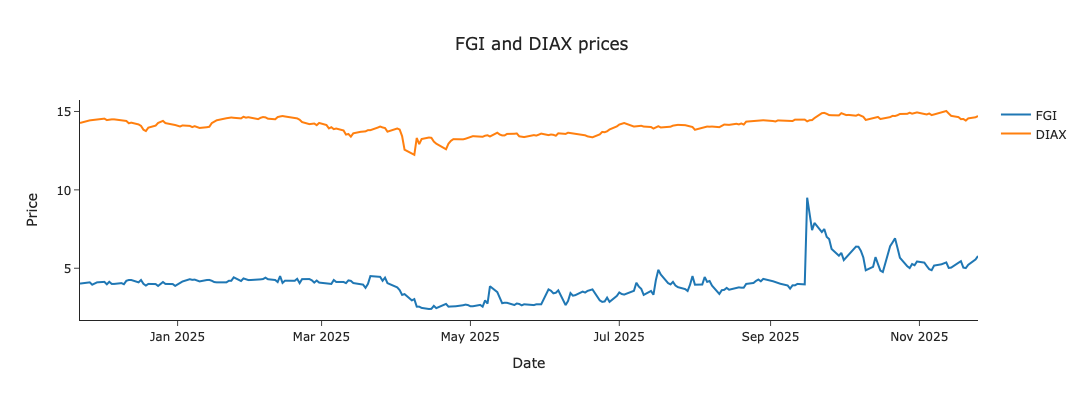

In [68]:
stock1=get_closing_data('FGI.parquet').iloc[-252:]
stock2=get_closing_data('DIAX.parquet').iloc[-252:]
fig = go.Figure()
fig.add_trace(go.Scatter(x=stock1.index, y=stock1.values, name='FGI', mode='lines'))
fig.add_trace(go.Scatter(x=stock2.index, y=stock2.values, name='DIAX', mode='lines'))
fig.update_layout(
    title={'text':'FGI and DIAX prices', 'x':0.5}, 
    xaxis_title="Date", yaxis_title="Price", template="simple_white", height=400, width=800)
fig.show()

I will now model the distribution of the spread between these two stock's prices using Kernel Density Estimation, a non-parametric method:

In [19]:
spread_df = stock1 - stock2
spread_df = spread_df.dropna()
spread_df = spread_df.rename('Spread')
spread_df.index.name='Date'

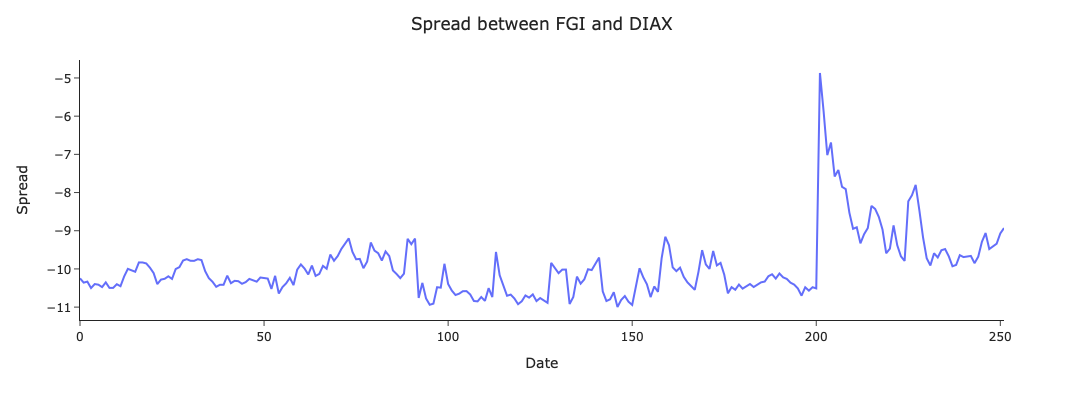

In [74]:
fig = px.line(spread_df)
fig.update_layout(title={'text':'Spread between FGI and DIAX', 'x':0.5}, xaxis_title="Date", yaxis_title="Spread", width=800, height=400, template="simple_white", showlegend=False)
fig.show()

Now, the overall time series does **not** look awfully stationary! Some stationarity held from Nov 2024 to about Sep 2025, after which a shock knocked the spread up to -5, before settling back down at a new stationary mean of about -8. This suggests that mean-reversion holds on short timeframes, but the mean itself may change in response to shocks.

Our statarb strategy will assume that mean-reversion occurs within less than a year. Thus, each strategy will have an time-in-force of a few months. In addition, ByteQuant's risk management module will place a stop-loss on the strategy informed by the observed variance around the mean in the "pockets" of stationarity to protect against shocks as the one seen above. 

To get a sense of the distribution of spreads, below is a histogram:

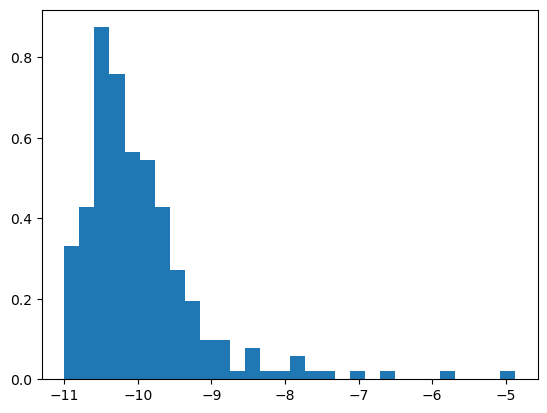

In [27]:
plt.hist(spread_df, bins=30, density=True)
plt.show()

Given that the distributed does not immediately look Gaussian (or any other common parametric distribution), I will estimate the density with KDE:

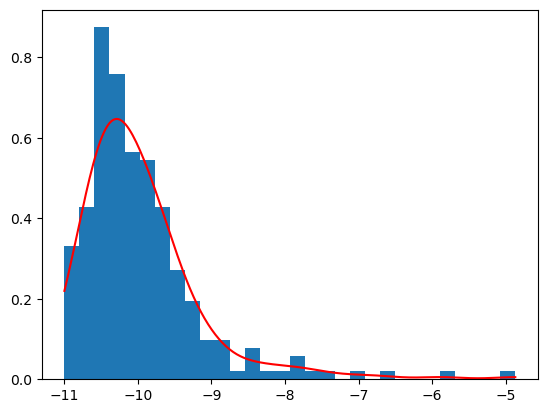

In [32]:
from sklearn.neighbors import KernelDensity

spread_df = stock1 - stock2
spread_df = spread_df.dropna().values.reshape(-1,1)

kde = KernelDensity(kernel='gaussian', bandwidth=0.3).fit(spread_df)
plt.hist(spread_df, bins=30, density=True)
x = np.linspace(min(spread_df), max(spread_df), 252).reshape(-1,1)
plt.plot(x, np.exp(kde.score_samples(x)), 'r-')
plt.show()

Thus, if the current spread between the stocks sits in the extreme tails of this parametric distribution, we can initiate a strategy (go long the one stock and short the other) in the hope that the spread reverts to the higher-probability areas of the distribution.

#### Summary of this basic StatArb strategy:
1. Randomly sample $k$ stocks from the ~7000 at our disposal
2. Perform a cointegration test on all possible unique pairs from that sample; sort the results in ascending order by p-value
3. Filter out the pairs that achieved a p-value less than  $\alpha = 0.05$, then randomly sample $j$ pairs from this subset
4. Obtain the spread time series of each pair, then estimate each pair's spread distribution with KDE
5. For each pair: If the current spread between two stocks is "extreme" e.g. $p < 0.05$: long the one and short the other
   (with this strategy unwinding on some expiry date or when some target profit level is reached)

*Darren Dube - Data Science student at Stellenbosch University. Catch me on [LinkedIn](https://linkedin.com/in/darrendube)*